In [52]:
import os
import pickle
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from openretina.h5_handling import load_h5_into_dict
from openretina.misc import print_h5_structure
from scipy.interpolate import interp1d
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def upsample_traces(
    triggertimes,
    traces,
    tracestimes,
    stim_id,
    stim_framerate: Optional[int] = None,
    target_fs=15,
):
    """
    stim_framerate: int    Needed if we are using the moving bar or chirp stimulus.
    """
    if stim_id == 5:
        # if movie, upsample triggertimes to get 1 trigger per frame, (instead of just 1 trigger at the start of the sequence)
        # 4.966666 is roughly the average time between triggers in the movie stimulus?
        # TODO understand why 4.96666 and not 5
        # 5 * 30 is 5 seconds at 30 fps for each clip
        upsampled_triggertimes = [np.linspace(t, t + 4.9666667, 5 * 30) for t in triggertimes]
        upsampled_triggertimes = np.concatenate(upsampled_triggertimes)
    elif stim_id == 0:
        up_factor = int(target_fs / stim_framerate)
        ifi = 1 / stim_framerate
        upsampled_triggertimes = [np.linspace(t, t + ifi, up_factor, endpoint=False) for t in triggertimes]
        upsampled_triggertimes = np.concatenate(upsampled_triggertimes)
    else:
        raise NotImplementedError(f"Stimulus ID {stim_id} not implemented")

    upsampled_responses = []
    for n, trace in enumerate(traces):
        response = interp1d(tracestimes[n].flatten(), trace.flatten(), kind="linear")(upsampled_triggertimes)
        upsampled_responses.append(response)

    upsampled_responses = np.stack(upsampled_responses, axis=0)
    upsampled_responses = upsampled_responses / np.std(
        upsampled_responses, axis=1, keepdims=True
    )  # normalize response std

    return upsampled_responses

In [25]:
lara_export_path = (
    "/Data/fd_export/2024-03-27_neuron_data_stim_c285329_responses_483c12d.h5"
)
old_export_path = (
    "/Data/fd_export/2024-01-11_neuron_data_stim_c285329_responses_483c12d.pkl"
)
new_export_path = (
    "/Data/fd_export/2024-03-25_neuron_data_responses_484c12d_djimaging.h5"
)

In [26]:
lara_data = load_h5_into_dict(lara_export_path)

Loading HDF5 file contents:   0%|          | 0/1296 [00:00<?, ?item/s]

In [27]:
example_field = "session_1_ventral1_20200226"
old_name = "20200226_1_1"

In [28]:
stim_dataloaders_dict = pickle.load(open(old_export_path, "rb"))

In [54]:
def convert_field_name(example_field):
    parts = example_field.split("_")
    date = parts[-1]
    session = parts[1].split("_")[0]
    ventral = parts[2].split("ventral")[1]
    old_name = f"{date}_{session}_{ventral}"
    return old_name

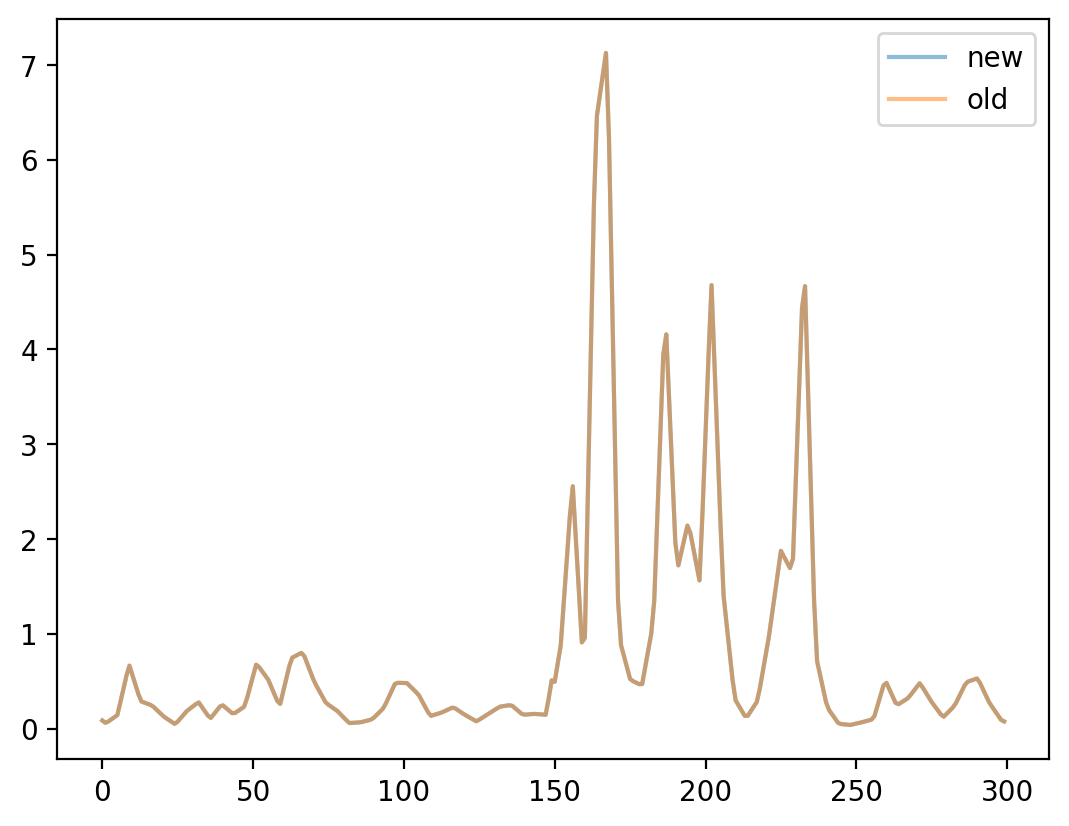

In [57]:
natural_traces = lara_data[example_field]["natural_inferred_spikes"]
natural_triggertimes = lara_data[example_field]["natural_trigger_times"][
    0
]  #! They are all the same!
natural_tracestimes = lara_data[example_field]["natural_traces_times"]

example_upsampled = upsample_traces(
    triggertimes=natural_triggertimes,
    traces=natural_traces,
    tracestimes=natural_tracestimes,
    stim_id=5,
)

plt.plot(example_upsampled[0, :300], label="new", alpha=0.5)
plt.plot(
    stim_dataloaders_dict[convert_field_name(example_field)]["responses_final"][
        0, :300
    ],
    label="old",
    alpha=0.5,
)
plt.legend()

In [66]:
for session in tqdm(lara_data.keys()):
    triggertimes = lara_data[session]["natural_trigger_times"][0]
    natural_traces = lara_data[session]["natural_inferred_spikes"]
    tracestimes = lara_data[session]["natural_traces_times"]
    upsampled_natural = upsample_traces(
        triggertimes=triggertimes,
        traces=natural_traces,
        tracestimes=tracestimes,
        stim_id=5,
    )

    old_data = stim_dataloaders_dict[convert_field_name(session)]["responses_final"]

    assert np.allclose(upsampled_natural, old_data)
print("All data is the same")

  0%|          | 0/72 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (131,18450) (105,18450) 